In [1]:
%reset -f
import numpy as np
import pandas as pd
import random
import math
import os
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as rnn_utils
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from tqdm.notebook import tqdm
from math import sqrt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

In [2]:
mat = scipy.io.loadmat('NASAtrain_ICA_part.mat') #reads dataset
cellsName = [keys for keys in mat.keys() if not keys.startswith('__')]
numCell = len(cellsName)
print("mat structure:", numCell)
print("Name of cells:", cellsName)

mat structure: 4
Name of cells: ['train1', 'train2', 'train3', 'train4']


In [3]:
# Extract data from matalab to list in python
Sequences = []
Labels = []
Length_ICA = []
windows = 15

for i in range(numCell):
    mat[cellsName[i]][0][0].dtype.names
    mat[cellsName[i]][0][0]['data'][0][0].shape
    numCycle = len(mat[cellsName[i]][0][0]['data'])
    numCycle

    ICA = [[] for _ in range(numCycle)]
    label = [[] for _ in range(numCycle)]
    length = [[] for _ in range(numCycle)]
    Sequences_temp = [[] for _ in range(numCycle-windows)]
    Labels_temp = [[] for _ in range(numCycle-windows)]

    for j in range(numCycle):
      ICA[j] =  torch.tensor(mat[cellsName[i]][0][0]['data'][j][0]).float() # list contain tensor sequences
      label[j] = torch.tensor(mat[cellsName[i]][0][0]['label'][j][0]).float()
      length[j] = len(mat[cellsName[i]][0][0]['data'][j][0][0])

    for j in range(windows, numCycle):
      Sequences_temp[j - windows] = ICA[j - windows:j]
      #Labels_temp[j - windows] = label[j - windows:j] #collect all labels
      Labels_temp[j - windows] = label[j] # Only labels for final cycle

    Length_ICA.extend(length)
    Sequences.extend(Sequences_temp)
    Labels.extend(Labels_temp)
# The dataset include the packed datas(size = windows) in format of list
# All datas are already the tensor format
print(f"size of ICA curves: {len(Length_ICA)}")
print(f"size of DataSequences(s): {len(Sequences)}")
print(f"Typical element of Dataset: {len(Sequences[1])}")
for i in range(len(Sequences[1])):
  print(Sequences[0][i].shape)

print(Labels[1])

size of ICA curves: 636
size of DataSequences(s): 576
Typical element of Dataset: 15
torch.Size([3, 55])
torch.Size([3, 57])
torch.Size([3, 57])
torch.Size([3, 58])
torch.Size([3, 56])
torch.Size([3, 57])
torch.Size([3, 58])
torch.Size([3, 57])
torch.Size([3, 58])
torch.Size([3, 58])
torch.Size([3, 58])
torch.Size([3, 58])
torch.Size([3, 58])
torch.Size([3, 58])
torch.Size([3, 60])
tensor(0.9710)


In [4]:
Sequences[0][i][2]

tensor([ 221.2068,  570.8605,  895.0165, 1123.0601, 1309.8953, 1492.1598,
        1650.4678, 1782.8020, 1912.1311, 2031.6567, 2129.3669, 2222.8301,
        2306.3638, 2383.7903, 2482.8816, 2595.6233, 2701.7517, 2788.4863,
        2843.0508, 2861.5823, 2896.3113, 2932.9468, 2930.4512, 2895.4392,
        2842.2422, 2828.8110, 2836.5410, 2865.0112, 2892.6895, 2957.5356,
        3035.6055, 3070.0691, 3127.2673, 3218.6035, 3276.0825, 3312.8311,
        3403.6404, 3475.6936, 3513.7468, 3568.9919, 3604.4565, 3610.1230,
        3607.4746, 3626.5474, 3665.3650, 3704.9353, 3748.0488, 3767.9600,
        3831.1030, 3905.0044, 3965.9045, 4035.7036, 4085.1494, 4140.2612,
        4242.4438, 4320.6621, 4398.1504, 4484.5649, 4294.3491, 3179.2263])

torch.Size([3, 57])
torch.Size([3, 58])
torch.Size([3, 58])
torch.Size([3, 60])
torch.Size([3, 58])
torch.Size([3, 57])
torch.Size([3, 55])
torch.Size([3, 56])
torch.Size([3, 56])
torch.Size([3, 56])
torch.Size([3, 55])
torch.Size([3, 54])
torch.Size([3, 55])
torch.Size([3, 54])
torch.Size([3, 55])


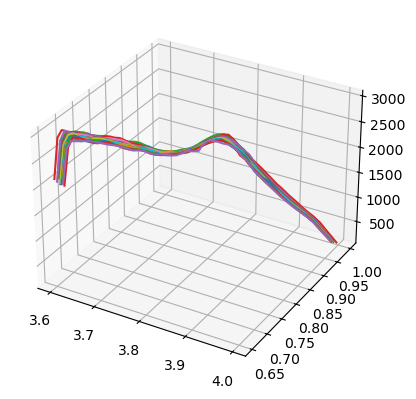

In [5]:
ax = plt.figure().add_subplot(projection='3d')
n = 100
for i in range(len(Sequences[1])):
  print(Sequences[n][i].shape)
  ax.plot(np.array(Sequences[n][i][0]), np.array(Sequences[n][i][1]), np.array(Sequences[n][i][2]), label='ICA')  

In [24]:
# Pack to dataset useing customised class
class MultiSequenceDataset(Dataset):
  # Here each returen will be a list of sequences and corresponding label
  # Demo like: Sequences, Labels = dataset[i]
    def __init__(self, data_points, targets):
        self.data_points = data_points
        self.targets = targets

    def __len__(self):
        return len(self.data_points)

    def __getitem__(self, idx):
        return self.data_points[idx], self.targets[idx]

    def total_sequences(self):
        return sum(len(sequences) for sequences in self.data_points)

dataset = MultiSequenceDataset(Sequences, Labels)
# Get the number of top-level data points in the dataset
print("Number of top-level data points in the dataset:", len(dataset))

# Get the total number of sequences in the dataset
print("Total number of sequences in the dataset:", dataset.total_sequences())

def collate_fn(batch):
    data_points, targets = zip(*batch)
    return data_points, torch.tensor(targets)

dataloader = DataLoader(dataset, batch_size=128, collate_fn=collate_fn)

def rmse_loss(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets) ** 2))

Number of top-level data points in the dataset: 576
Total number of sequences in the dataset: 8640


In [26]:
# Self-Attention Mechanism
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(SelfAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.linear = nn.Linear(embed_dim, embed_dim)  # Project the output back to the original dimension

    def forward(self, x):
        attn_output, _ = self.multihead_attn(x, x, x)
        return self.linear(attn_output)

# Transformer Feature Extractor
class TransformerFeatureExtractor(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, dropout=0.1):
        super(TransformerFeatureExtractor, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

    def forward(self, src):
        return self.transformer_encoder(src)

class DualCNNTransformerRegressor(nn.Module):
    def __init__(self, input_channels, cnn1_out_channels, cnn2_out_channels, transformer_embed_dim, output_dim, dropout_prob=0.3, num_heads=4, num_layers=2):
        super(DualCNNTransformerRegressor, self).__init__()
        # First CNN layer
        self.conv1 = nn.Conv1d(input_channels, cnn1_out_channels, kernel_size=5, stride=2, padding=1)
        self.bn1 = nn.BatchNorm1d(cnn1_out_channels)
        
        # Second CNN layer
        self.conv2 = nn.Conv1d(cnn1_out_channels, cnn2_out_channels, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm1d(cnn2_out_channels)
        
        # Self-Attention for arranging the same sequence length
        self.self_attention = SelfAttention(embed_dim=cnn2_out_channels, num_heads=num_heads)
        
        # Project attention output to transformer embedding dimension
        self.attn_to_transformer = nn.Linear(cnn2_out_channels, transformer_embed_dim)
        
        # Transformer for feature sequence handling
        self.transformer = TransformerFeatureExtractor(embed_dim=transformer_embed_dim, num_heads=num_heads, num_layers=num_layers)
        
        # Fully connected layer for final regression output
        self.fc1 = nn.Linear(transformer_embed_dim, output_dim)

    def forward(self, x):
        batch_size = len(x)
        processed_sequences = []

        for sequences in x:
            conv_out = []
            for seq in sequences:
                seq = seq.unsqueeze(0)  # Add batch dimension
                seq = F.relu(self.bn1(self.conv1(seq)))
                seq = F.relu(self.bn2(self.conv2(seq)))
                seq = seq.permute(0, 2, 1)  # Permute to [batch_size, seq_len, embed_dim] for self-attention
                attn_out = self.self_attention(seq)  # Apply self-attention
                attn_out = attn_out.mean(dim=1)  # Mean pooling over the sequence length
                attn_out = self.attn_to_transformer(attn_out)  # Project to transformer embedding dimension
                conv_out.append(attn_out)
            conv_out = torch.stack(conv_out, dim=1)[0]  # Convert to [batch_size, num_sequences, transformer_embed_dim]
            processed_sequences.append(conv_out)

        processed_sequences = torch.stack(processed_sequences)  # Convert to [batch_size, num_sequences, transformer_embed_dim]

        transformer_out = self.transformer(processed_sequences)
        transformer_out = transformer_out.mean(dim=1)  # Mean pooling over the sequence length
        
        output = self.fc1(transformer_out)
        return output

# Example usage
input_channels = 3  # Three input channels (padded sequences)
cnn1_out_channels = 32
cnn2_out_channels = 16
transformer_embed_dim = 64
output_dim = 1  # Single value output for regression

model = DualCNNTransformerRegressor(input_channels, cnn1_out_channels, cnn2_out_channels, transformer_embed_dim, output_dim)


(process:6940): Pango-WARNING **: 02:12:59.101: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


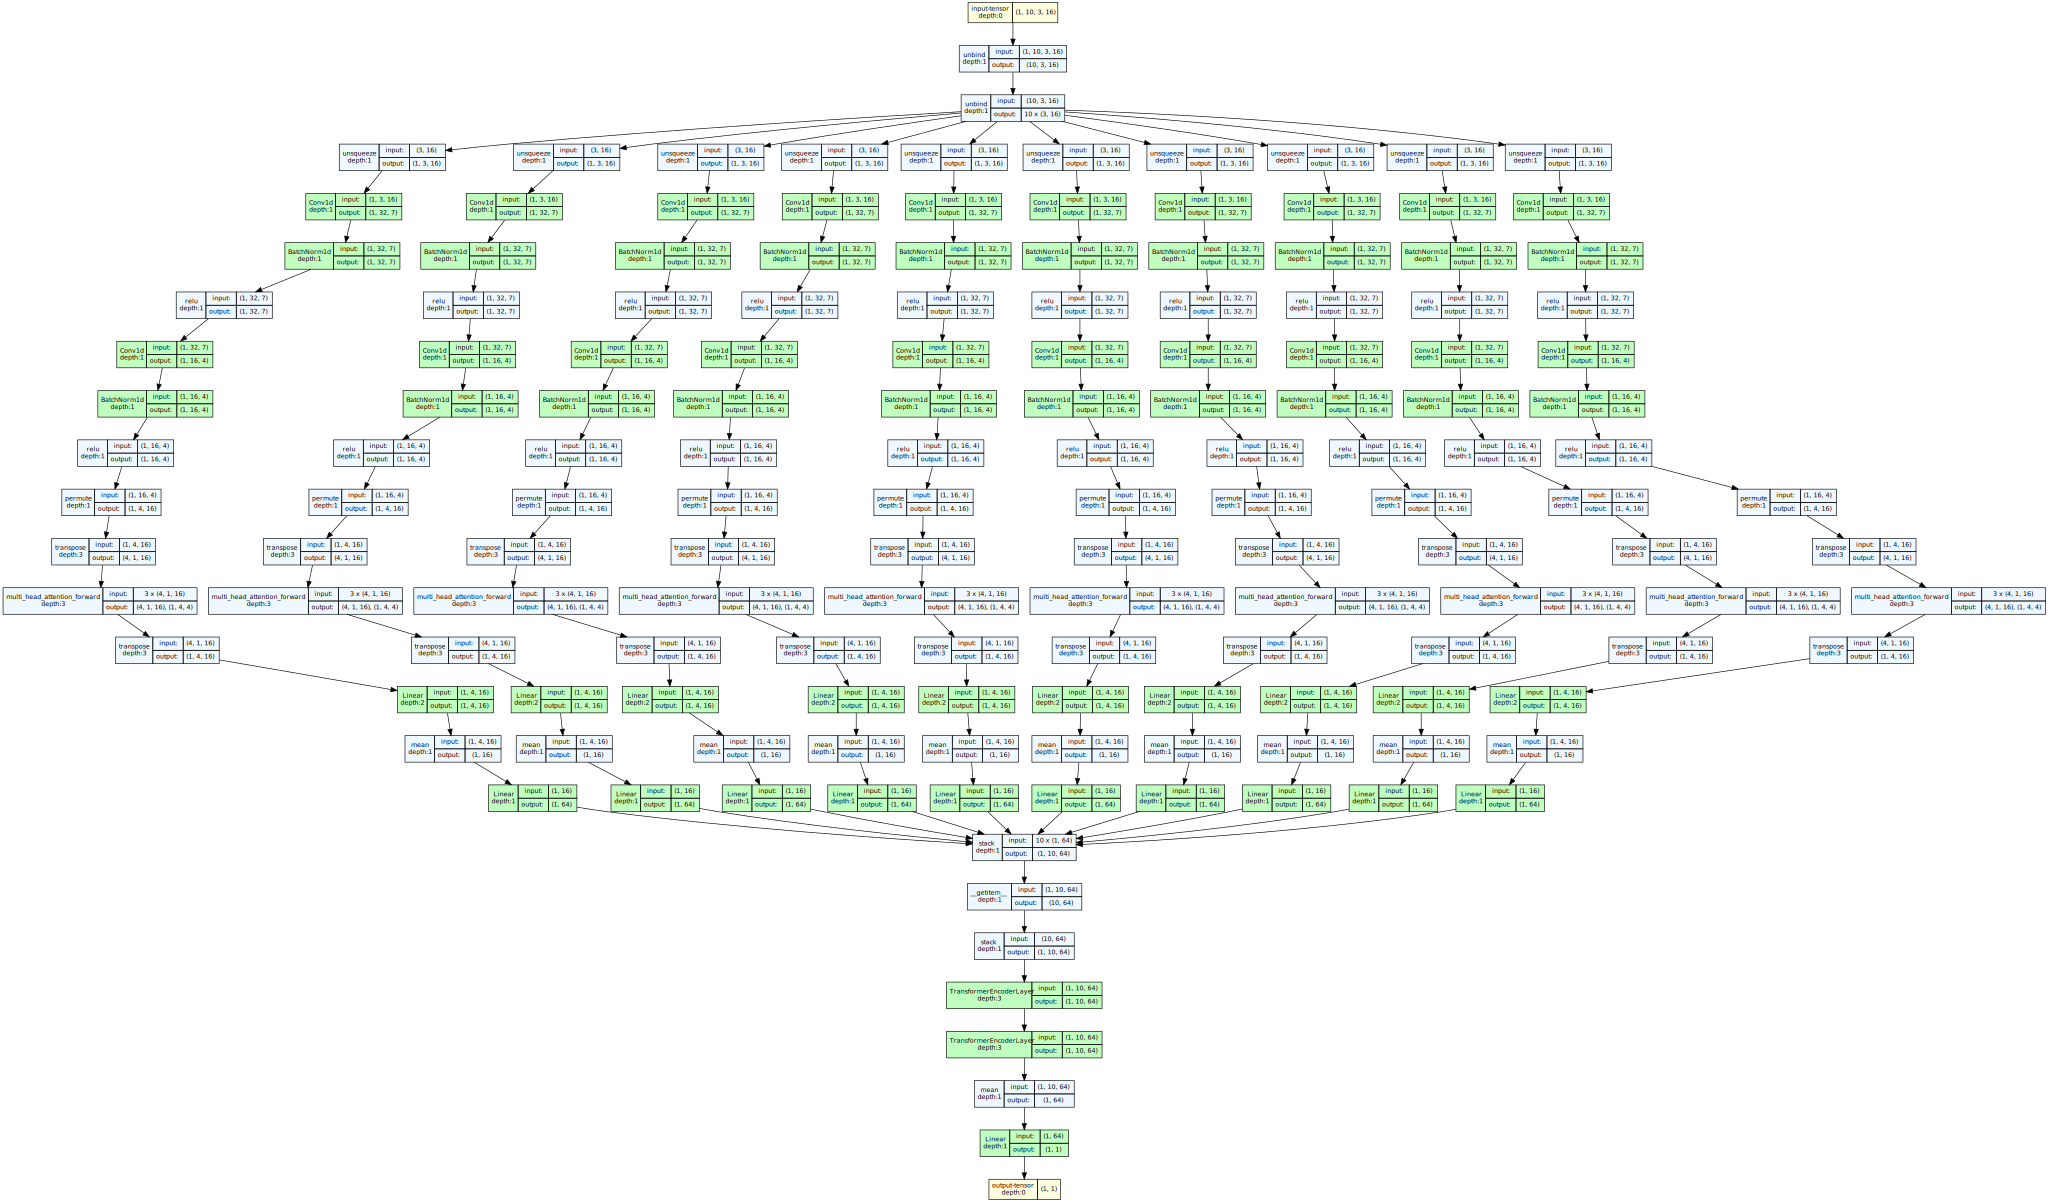

In [28]:
from torchview import draw_graph
batch_size = 2
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(model, input_size=(1, 10,3,16), device='cuda')
model_graph.visual_graph


In [29]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to device
model = model.to(device)

# Training parameters
num_epochs = 100
learning_rate = 0.001

# Optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Split the dataset into training and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=2, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

# RMSE Loss Function
def rmse_loss(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets) ** 2))

# Lists to store losses
train_losses = []
test_losses = []

# Variable to store the best model and the lowest loss
best_model_state = None
lowest_train_loss = float('inf')

# Training and testing loop with inspection
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs = [[seq.to(device) for seq in sequence] for sequence in inputs]
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = rmse_loss(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}")

    # Save the best model based on training loss
    if train_loss < lowest_train_loss:
        lowest_train_loss = train_loss
        best_model_state = model.state_dict()

    # Test the model after each epoch
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = [[seq.to(device) for seq in sequence] for sequence in inputs]
            targets = targets.to(device)
            outputs = model(inputs)
            loss = rmse_loss(outputs.squeeze(), targets)
            test_loss += loss.item()
    
    test_loss = test_loss / len(test_loader)
    test_losses.append(test_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}")

    # Adjust the learning rate based on the validation loss
    scheduler.step(test_loss)

# Save the best model to a file
torch.save(best_model_state, 'best_model.pth')

# Plot the losses using RMSE
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training RMSE')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.title('Training and Test RMSE')
plt.show()


Using device: cuda


TypeError: list indices must be integers or slices, not tuple